In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from copy import deepcopy
import matplotlib.pyplot as plt

Select more important feature of dataset to predict labels with applying model and with calculation Pearson's correlation.

In [3]:
# Prepare data
X = np.reshape([list(map(int, i.split())) for i in pd.read_csv("arcene_train.data", header=None)[0][::]], (100, -1))
y_train = list(map(int, pd.read_csv("arcene_train.labels", header=None)[0]))
X_v = np.reshape([list(map(int, i.split())) for i in pd.read_csv("arcene_valid.data", header=None)[0]], (100, -1))
Y_v = [int(i) for i in pd.read_csv("arcene_valid.labels", header=None)[0]]

In [4]:
mod = LinearSVC(penalty="l1", dual=False)
mod_to_fit = KNeighborsClassifier()

In [5]:
poppers_rang = []
for i in range(len(X[0])):
    poppers_rang.append(np.mean(cross_val_score(mod, np.reshape([row[i] for row in X], (-1, 1)), [j for j in y_train], cv=2)))

In [6]:
queue_to_del = list(sorted(enumerate(poppers_rang), key=lambda x: x[1], reverse=True))

In [7]:
features = []
k = 50
for i in queue_to_del[-k::]:
    features.append([a[i[0]] for a in X])

In [8]:
mod_to_fit.fit(np.reshape(features, (100, -1)), [j for j in y_train])
cross_val_score(mod_to_fit, X, [j for j in y_train])

array([0.76470588, 0.67647059, 0.84375   ])

In [9]:
features_v = []
for i in queue_to_del[-k::]:
    features_v.append([a[i[0]] for a in X_v])
Ypr_v = mod_to_fit.predict(np.reshape(features_v, (100, -1)))

In [10]:
def score_red(k):
    features = [[j[queue_to_del[0][0]]] for j in X]
    for i in queue_to_del[1:k]:
        [features[ix].append(X[ix][i[0]]) for ix in range(100)]
    X_ref = np.reshape(features, (100, -1))
    mod_to_fit.fit(X_ref, [j for j in y_train])
    preds = [[j[queue_to_del[0][0]]] for j in X_v]
    for i in queue_to_del[1:k:]:
        [preds[ix].append(X_v[ix][i[0]]) for ix in range(100)]
    X_pred = np.reshape(preds, (100, -1))
    Ypr_v = mod_to_fit.predict(X_pred)
    return sum(Ypr_v==Y_v)/len(Ypr_v)

In [11]:
x = list(range(1,100))
y = list(map(lambda x: score_red(x), x))

mean 0.7681818181818183
max 0.83 index 65


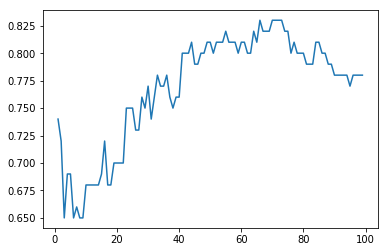

In [15]:
plt.plot(x,y) #100 bests single features
print('mean', np.mean(y))
print('max', max(y), 'index', np.argmax(y))

In [20]:
score_red(66) # 66 features from sorted(feature_list) is good: result of KNeighbors

0.83

In [22]:
n_fs = len(y_train)
queue_pears = [min(list(map(abs, pearsonr([a[i] for a in X], [j for j in y_train])))) for i in range(n_fs)]

In [23]:
pqueue = sorted(list(enumerate(queue_pears)), key=lambda x: x[1], reverse=True)


In [24]:
def score_p(k):
    pq = [[j[pqueue[0][0]]] for j in X]
    for i in pqueue[1:k]:
        [pq[ix].append(X[ix][i[0]]) for ix in range(100)]
    X_ref = np.reshape(pq, (100, -1))
    mod_to_fit.fit(X_ref, [j for j in y_train])
    preds = [[j[pqueue[0][0]]] for j in X_v]
    for i in pqueue[1:k]:
        [preds[ix].append(X_v[ix][i[0]]) for ix in range(100)]
    X_pred = np.reshape(preds, (100, -1))
    Ypr_v = mod_to_fit.predict(X_pred)
    return sum(Ypr_v==Y_v)/len(Ypr_v)

In [25]:
x1 = list(range(1,100))
y1 = list(map(lambda x: score_p(x), x))

mean 0.7096969696969699
total max 0.79
first max 0.78  index  34


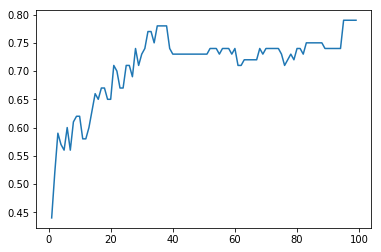

In [30]:
plt.plot(x1,y1) #100 best with pearson corellation
print('mean', np.mean(y1))
print('total max', max(y1))
print('first max', max(y1[:50:]), ' index ', np.argmax(y1[:50:]))

In [32]:
score_p(35) # 35 features: result by correlation calculation

0.78

In [33]:
def best_w(k_w):
    features = [[] for _ in range(100)]
    prev_score = 0
    selected = []
    for i in queue_to_del[::-1]:
        checker = deepcopy(features)
        if checker == []: [checker.append(j[i[0]]) for j in X]
        else:
            for ix in range(100):
                checker[ix].append(X[ix][i[0]])
        cur_score = np.mean(cross_val_score(mod, np.reshape(checker, (100, -1)), [j for j in y_train], cv=5))
        if  cur_score > prev_score:
            selected.append(i[0])
            prev_score = cur_score
            features = deepcopy(checker)
    return selected

In [34]:
get_selected = best_w(0)

In [35]:
def score_w(k):
    num = get_selected[:k:]
    pq = [[j[num[0]]] for j in X] 
    for i in num[1::]:
        [pq[ix].append(X[ix][i]) for ix in range(100)]
    X_ref = np.reshape(pq, (100, -1))
    mod_to_fit.fit(X_ref, [j for j in y_train])
    preds = [[j[num[0]]] for j in X_v]
    for i in num[1::]:
        [preds[ix].append(X_v[ix][i]) for ix in range(100)]
    X_pred = np.reshape(preds, (100, -1))
    Ypr_v = mod_to_fit.predict(X_pred)
    return sum(Ypr_v==Y_v)/len(Ypr_v)

In [36]:
xw = list(range(1,len(get_selected)))
yw = list(map(lambda x: score_w(k=x), xw))


mean 0.6153846153846153
max 0.77


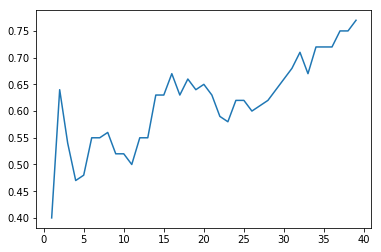

In [37]:
plt.plot(xw, yw)
print('mean', np.mean(yw))
print('max', max(yw))

In [623]:
print(score_w(8)) #8 best features

0.8
